In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/jdunnmon/repos/metal')
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import pandas as pd

In [4]:
# Setting data location
eeg_data_path = '/mnt/discovery-nas/Encrypted-Data-1/data/reports/eeg'
#eeg_data_path = '/home/jdunnmon/research/re/projects/eeg/data/reports'
eeg_data_file = 'reports_unique_for_hl_mm.txt'
data_path = os.path.join(eeg_data_path, eeg_data_file)

# Loading data
df_eeg = pd.read_csv(data_path, sep='\t', index_col=0).dropna(how='all')

In [5]:
# Testing a single EEGNote
from eeg_utils import EEGNote
noteObj = EEGNote(df_eeg['note_uuid'][100], df_eeg['note'][100])

In [68]:
import dill
from eeg_utils import parse_eeg_docs

# Parsing documents -- note that 1 = abnormal, 2 = normal!

eeg_note_dill = 'parsed_eeg_notes.dill'
eeg_note_dill_path = os.path.join(eeg_data_path, eeg_note_dill)

if os.path.exists(eeg_note_dill_path):
    print('Loading pre-parsed EEG notes...')
    with open(eeg_note_dill_path, 'rb') as af:
        docs = dill.load(af)
else:
    print('Parsing EEG notes...')
    docs = parse_eeg_docs(df_eeg, use_dask=False)
    with open(eeg_note_dill_path,'wb') as af:
        dill.dump(docs, af)

Loading pre-parsed EEG notes...


In [69]:
# These are docs with empty sections -- most look like they're not EEG reports!
from eeg_utils import get_empty_docs
empty_docs = get_empty_docs(docs)

In [70]:
# Removing empty EEG docs
eeg_docs = list(set(docs)-set(empty_docs))
print(f'Number of EEG Reports with Sections: {len(eeg_docs)}')

Number of EEG Reports with Sections: 9684


In [81]:
import numpy as np
from eeg_utils import create_data_split

# Shuffling and setting seed
np.random.seed(1701)
np.random.shuffle(eeg_docs)

# Creating data split
train_docs, dev_docs, test_docs = create_data_split(eeg_docs)
docs_list = [train_docs, dev_docs, test_docs]

In [82]:
# Computing dev/test label balance
Y_dev = np.array([doc.gold_label for doc in dev_docs])
Y_test = np.array([doc.gold_label for doc in test_docs])

dev_balance= np.sum(Y_dev == 1)/len(Y_dev)
test_balance = np.sum(Y_test == 1)/len(Y_test)

print(f'Dev positive percentage: {dev_balance}')
print(f'Test positive percentage: {test_balance}')

Dev positive percentage: 0.22641509433962265
Test positive percentage: 0.19811320754716982


In [83]:
import re
from eeg_lfs import *
from eeg_utils import get_section_with_name

In [84]:
from metal.analysis import single_lf_summary, confusion_matrix

# Testing single LF
lf_test = lf_impression_section_positive

# Computing labels
Y_lf = np.array([lf_test(doc) for doc in dev_docs])
single_lf_summary(Y_lf, Y=Y_dev)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,1,0.141509,0.0,0.0,9,6,0.6


In [85]:
# Print confusion matrix
conf = confusion_matrix(Y_dev, Y_lf)

        y=1    y=2   
 l=1     9      0    
 l=2     6      0    


In [86]:
lfs = [
    lf_normal_interp_not_seizure,
    lf_abnormal_interp_with_seizure,
    lf_findall_interp_with_seizure,
    lf_findall_abnl_interp_without_seizure,
    lf_abnl_interp_negexsp_seizure,
    lf_findall_interp_negex_seizure,
    lf_seizure_section,
    lf_impression_section_negative,
    lf_impression_section_positive,
    lf_spikes_in_impression,
    lf_extreme_words_in_impression
]

In [87]:
from scipy.sparse import csr_matrix
import dask
from dask.diagnostics import ProgressBar
from eeg_utils import evaluate_lf_on_docs, create_label_matrix
import pickle

# Resetting LFs
clobber_lfs = True
Ls_file = 'Ls_0p3.pkl'
Ys_file = 'Ys_0p3.pkl'

# Get lf names
lf_names = [lf.__name__ for lf in lfs]

# Loading Ls if they exist

Ls = []
Ys = []
if clobber_lfs or (not os.path.exists(Ls_file)):
    print('Computing label matrices...')
    for i, docs in enumerate([train_docs, dev_docs, test_docs]):
        Ls.append(create_label_matrix(lfs,docs))  
    with open(Ls_file,'wb') as af:
        pickle.dump(Ls, af)
    
    print('Creating label vectors...')
    Ys = [[],Y_dev, Y_test]
    with open(Ys_file,'wb') as af:
        pickle.dump(Ls, af)
else:
    print('Loading pre-computed label matrices...')
    with open(Ls_file,'rb') as af:
        Ls=pickle.load(af) 
        

# Create label matrices
#Ls = []
#for i, docs in enumerate([train_docs, dev_docs, test_docs]):
#    Ls.append(create_label_matrix(lfs,docs)) 
    
# Create Ys
Ys = [[], Y_dev, Y_test]

Computing label matrices...
[########################################] | 100% Completed |  1min 31.3s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s


In [118]:
from metal.analysis import lf_summary

# Analyzing LF stats
df_lf = lf_summary(Ls[1], Y=Y_dev, lf_names=lf_names)
df_lf

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_normal_interp_not_seizure,0,2,0.113208,0.113208,0.000000,12,0,1.000000
lf_abnormal_interp_with_seizure,1,"[1, 2]",0.811321,0.811321,0.311321,70,16,0.813953
lf_findall_interp_with_seizure,2,"[1, 2]",0.952830,0.952830,0.386792,80,21,0.792079
lf_findall_abnl_interp_without_seizure,3,2,0.094340,0.094340,0.094340,9,1,0.900000
lf_abnl_interp_negexsp_seizure,4,"[1, 2]",0.603774,0.603774,0.283019,64,0,1.000000
lf_findall_interp_negex_seizure,5,"[1, 2]",0.952830,0.952830,0.386792,95,6,0.940594
lf_seizure_section,6,"[1, 2]",0.452830,0.452830,0.235849,39,9,0.812500
lf_impression_section_negative,7,2,0.632075,0.632075,0.264151,62,5,0.925373
lf_impression_section_positive,8,1,0.141509,0.141509,0.084906,9,6,0.600000
lf_spikes_in_impression,9,1,0.150943,0.150943,0.113208,10,6,0.625000


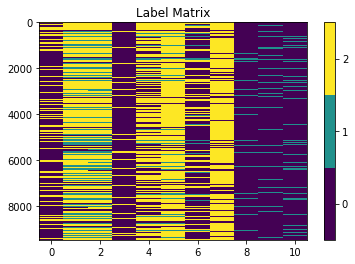

In [89]:
from metal.contrib.visualization.analysis import view_label_matrix, view_overlaps

# Viewing label matrix
view_label_matrix(Ls[0])

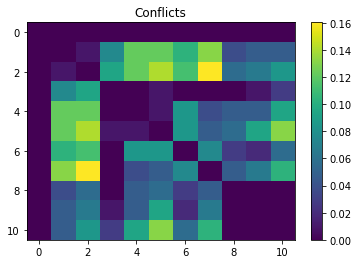

In [90]:
from  metal.contrib.visualization.analysis import view_conflicts

# Viewing conflicts
view_conflicts(Ls[1], normalize=True)

In [111]:
from metal.label_model import LabelModel
from metal.utils import LogWriter
from metal.tuners import RandomSearchTuner

# Creating metal label model
#label_model = LabelModel(k=2, seed=123)

# Creating search space
search_space = {
        'l2': {'range': [0.0001, 0.1], 'scale':'log'},           # linear range
        'lr': {'range': [0.0001, 0.01], 'scale': 'log'},  # log range
        }

searcher = RandomSearchTuner(LabelModel, log_dir='./run_logs',
               log_writer_class=None)

In [113]:
%%time
# Training label model
label_model = searcher.search(search_space, (Ls[1],Ys[1]), \
        train_args=[Ls[0]], init_args=[],
        init_kwargs={'k':2, 'seed':123}, train_kwargs={'n_epochs':100},
        max_search=20)

[0] Testing {'l2': 0.022632580213847252, 'lr': 0.0010988345706975783}
Computing O...
Estimating \mu...
[E:0]	Train Loss: 7.250
[E:10]	Train Loss: 5.419
[E:20]	Train Loss: 2.183
[E:30]	Train Loss: 0.489
[E:40]	Train Loss: 0.526
[E:50]	Train Loss: 0.445
[E:60]	Train Loss: 0.354
[E:70]	Train Loss: 0.339
[E:80]	Train Loss: 0.315
[E:90]	Train Loss: 0.292
[E:99]	Train Loss: 0.273
Finished Training
Accuracy: 0.943
        y=1    y=2   
 l=1    19      1    
 l=2     5     81    
[1] Testing {'l2': 0.00013226749681985027, 'lr': 0.008529621752314961}
Computing O...
Estimating \mu...
[E:0]	Train Loss: 8.901
[E:10]	Train Loss: 0.885
[E:20]	Train Loss: 0.912
[E:30]	Train Loss: 0.308
[E:40]	Train Loss: 0.181
[E:50]	Train Loss: 0.109
[E:60]	Train Loss: 0.076
[E:70]	Train Loss: 0.062
[E:80]	Train Loss: 0.055
[E:90]	Train Loss: 0.051
[E:99]	Train Loss: 0.049
Finished Training
Accuracy: 0.802
        y=1    y=2   
 l=1    21     18    
 l=2     3     64    
[2] Testing {'l2': 0.03485789928918552, 'lr':

In [114]:
# Saving best model
searcher._save_best_model(label_model)

In [96]:
# Getting scores
scores = label_model.score((Ls[1], Ys[1]), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.925
Precision: 0.864
Recall: 0.792
F1: 0.826
        y=1    y=2   
 l=1    19      3    
 l=2     5     79    


In [97]:
from metal.label_model.baselines import MajorityLabelVoter

# Checking if we beat majority vote
mv = MajorityLabelVoter(seed=123)
scores = mv.score((Ls[1], Ys[1]), metric=['accuracy', 'precision', 'recall', 'f1'])

Accuracy: 0.896
Precision: 0.724
Recall: 0.875
F1: 0.792
        y=1    y=2   
 l=1    21      8    
 l=2     3     74    


In [98]:
# Getting probabilistic training labels
# Y_train_ps stands for "Y[labels]_train[split]_p[redicted]s[oft]"
Y_train_ps = label_model.predict_proba(Ls[0])
Y_dev_ps = label_model.predict_proba(Ls[1])
Y_test_ps = label_model.predict_proba(Ls[2])
Y_ps = [Y_train_ps, Y_dev_ps, Y_test_ps]

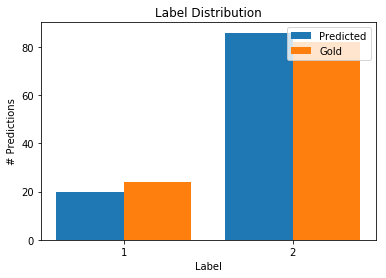

In [101]:
# Running some analysis 
from metal.contrib.visualization.analysis import plot_predictions_histogram
Y_dev_p = label_model.predict(Ls[1])
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

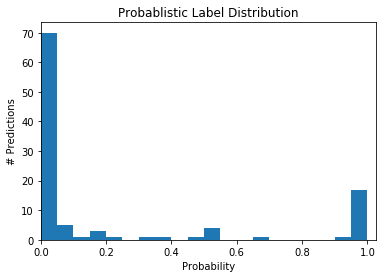

In [103]:
from  metal.contrib.visualization.analysis  import plot_probabilities_histogram

# Looking at probability histogram for training labels
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")

In [104]:
from  metal.analysis import confusion_matrix

# Printing confusion matrix
cm = confusion_matrix(Ys[1], Y_dev_p)

        y=1    y=2   
 l=1    18      6    
 l=2     2     80    


In [105]:
from metal.contrib.featurizers.embedding_featurizer import TrainableEmbeddingFeaturizer

# Defining featurizer
# TODO: use a different one for IdentityModule!
featurizer = TrainableEmbeddingFeaturizer()

# Getting raw input data
Xs = [[doc.tokens for doc in doc_split] for doc_split in [train_docs, dev_docs, test_docs]]

# Flattening input data and getting lengths for unflattening
X_flat = Xs[0]+Xs[1]+Xs[2]
lens = [len(X) for X in Xs]
lens = np.cumsum(lens)

# Fitting featurizer
featurizer.fit(X_flat, min_freq=100)

# Creating transformed data
X_trans = featurizer.transform(X_flat).float()

# Unflattening data
X_trans = [X_trans[:lens[0]], X_trans[lens[0]:lens[1]], X_trans[lens[1]:lens[2]]]

# Print embedding size
print(f'Embedding size: {len(X_trans[0][0])}')

Embedding size: 6756


In [106]:
from metal.end_model import EndModel
from metal.modules import LSTMModule, IdentityModule

# LSTM parameters
hidden_size = 50
embed_size = 100
vocab_size = len(X_trans[0][0]) # Update Metal to handle this more gracefully!
input_module = LSTMModule(embed_size, hidden_size, vocab_size = vocab_size)

# Identity parameters
#feature_size = len(X_trans[0][0])
#hidden_size = 1000
#input_module = IdentityModule()

# Defining end model
end_model = EndModel([embed_size,100,2], input_module=input_module, seed=123, use_cuda=True)

Using randomly initialized embeddings.
Embeddings shape = (6756, 100)
The embeddings are NOT FROZEN
Using lstm_reduction = 'max'

Network architecture:
Sequential(
  (0): Sequential(
    (0): LSTMModule(
      (embeddings): Embedding(6756, 100)
      (lstm): LSTM(100, 50, batch_first=True, bidirectional=True)
    )
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)



In [ ]:
import torch
from torch.utils.data import DataLoader
from metal.utils import MetalDataset

# Training end model
train_data = (X_trans[0].long(), torch.Tensor(Y_train_ps))
dev_data = (X_trans[1].long(), torch.Tensor(Ys[1]))
batch_size = 256

train_data = DataLoader(MetalDataset(*train_data), shuffle=True, batch_size=batch_size)
dev_data = DataLoader(MetalDataset(*dev_data), shuffle=True, batch_size = batch_size)

end_model.train_model(train_data, dev_data=dev_data, l2=0.00001, lr=0.001, batch_size=256, 
                num_workers=8, n_epochs=10, print_every=1, validation_metric='accuracy')

# Emptying cuda cache (add this to metal?)
torch.cuda.empty_cache()



  0%|          | 0/37 [00:00<?, ?it/s]

Using GPU...




  0%|          | 0/37 [00:34<?, ?it/s, avg_loss=0.683]

  3%|▎         | 1/37 [00:34<20:27, 34.09s/it, avg_loss=0.683]

  3%|▎         | 1/37 [01:08<41:07, 68.53s/it, avg_loss=0.636]

  5%|▌         | 2/37 [01:08<19:59, 34.27s/it, avg_loss=0.636]

  5%|▌         | 2/37 [01:42<30:00, 51.43s/it, avg_loss=0.601]

  8%|▊         | 3/37 [01:42<19:25, 34.29s/it, avg_loss=0.601]

  8%|▊         | 3/37 [02:16<25:51, 45.64s/it, avg_loss=0.568]

 11%|█         | 4/37 [02:16<18:49, 34.23s/it, avg_loss=0.568]

 11%|█         | 4/37 [02:52<23:44, 43.17s/it, avg_loss=0.55] 

 14%|█▎        | 5/37 [02:52<18:25, 34.54s/it, avg_loss=0.55]

 14%|█▎        | 5/37 [03:27<22:06, 41.46s/it, avg_loss=0.528]

 16%|█▌        | 6/37 [03:27<17:51, 34.55s/it, avg_loss=0.528]

 16%|█▌        | 6/37 [04:01<20:46, 40.21s/it, avg_loss=0.51] 

 19%|█▉        | 7/37 [04:01<17:13, 34.46s/it, avg_loss=0.51]

 19%|█▉        | 7/37 [04:35<19:41, 39.39s/it, avg_loss=0.498]

 22%|██▏       | 8/37 [04:35<16:39, 34.46s/it, a

Saving model at iteration 0 with best score 0.774
[E:0]	Train Loss: 0.436	Dev score: 0.774




  0%|          | 0/37 [00:34<?, ?it/s, avg_loss=0.453]

  3%|▎         | 1/37 [00:34<20:27, 34.10s/it, avg_loss=0.453]

  3%|▎         | 1/37 [01:08<40:57, 68.27s/it, avg_loss=0.432]

  5%|▌         | 2/37 [01:08<19:54, 34.14s/it, avg_loss=0.432]

  5%|▌         | 2/37 [01:42<29:57, 51.36s/it, avg_loss=0.433]

  8%|▊         | 3/37 [01:42<19:24, 34.24s/it, avg_loss=0.433]

  8%|▊         | 3/37 [02:16<25:48, 45.55s/it, avg_loss=0.42] 

 11%|█         | 4/37 [02:16<18:47, 34.16s/it, avg_loss=0.42]

 11%|█         | 4/37 [02:52<23:40, 43.03s/it, avg_loss=0.423]

 14%|█▎        | 5/37 [02:52<18:21, 34.43s/it, avg_loss=0.423]

 14%|█▎        | 5/37 [03:26<22:02, 41.31s/it, avg_loss=0.419]

 16%|█▌        | 6/37 [03:26<17:47, 34.43s/it, avg_loss=0.419]

 16%|█▌        | 6/37 [04:01<20:48, 40.27s/it, avg_loss=0.415]

 19%|█▉        | 7/37 [04:01<17:15, 34.52s/it, avg_loss=0.415]

 19%|█▉        | 7/37 [04:35<19:39, 39.32s/it, avg_loss=0.411]

 22%|██▏       | 8/37 [04:35<16:37, 34.40s/it, 

In [36]:
# Evaluating performance
print("Label Model:")
score = label_model.score((Ls[2], Ys[2]), metric=['accuracy','precision', 'recall', 'f1'])

print()

print("End Model:")
score = end_model.score((X_trans[2].long(), Ys[2]), metric=['accuracy', 'precision', 'recall', 'f1'])

Label Model:
Accuracy: 0.943
Precision: 0.950
Recall: 0.792
F1: 0.864
        y=1    y=2   
 l=1    19      1    
 l=2     5     81    

End Model:
Accuracy: 0.774
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    24     82    


In [127]:
save_dest = os.path.dirname(searcher.save_path)
splits = ['train','dev','test']
save_csvs = True
results_df = {}
for ind, split in enumerate(splits):
    # Evaluating scores and writing to file
    doc_ids = [doc.doc_id for doc in docs_list[ind]]
    gm_marginals = [y for y in Y_ps[ind]]

    # Creating dataframe
    df_dict = {'id': doc_ids, 'gm_marginals':gm_marginals}
    df = pd.DataFrame(df_dict)
    results_df[split] = df
    
    # Writing dataframe
    if save_csvs:
        results_df[split].to_csv(os.path.join(save_dest, f'metal_results_{split}.csv'))

## SANDBOX